In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

%matplotlib inline

# Helper functions

In [13]:
def print_results(predictions = None):
    plt.figure()
    
    if predictions is not None:
        ax1 = plt.subplot(1, 2, 1)
        ax1.set_title('Predicted')
        ones = X[np.argwhere(predictions>0.5)]
        zeroes = X[np.argwhere(predictions<=0.5)]
        ax1.plot([s[0,0] for s in zeroes], [s[0,1] for s in zeroes], 'o', color = 'red')
        ax1.plot([s[0,0] for s in ones], [s[0,1] for s in ones], 'o', color = 'blue')

        ax2 = plt.subplot(1, 2, 2)
    else:
        ax2 = plt.subplot(1, 1, 1)
        
    ax2.set_title('Actual')
    ones = X[np.argwhere(Y==1)]
    zeroes = X[np.argwhere(Y==0)]
    ax2.plot([s[0,0] for s in zeroes], [s[0,1] for s in zeroes], 'o', color = 'red')
    ax2.plot([s[0,0] for s in ones], [s[0,1] for s in ones], 'o', color = 'blue')
    
def accuracy(y, y_hat):
    y_hat_mod = [1 if x > 0.5 else 0 for x in y_hat]
    correct = 0
    for i in range(len(y)):
        if y_hat_mod[i] == y[i]:
            correct += 1
    return (float(correct)/float(len(y)))

# Generate data

In [5]:
X = []
Y = []
limit_x1 = int(100)
limit_x2 = int(100)
bounds_x1 = np.array([18., 90., 45., 67.])
bounds_x2 = np.array([19., 90.])
div_x1 = 10
div_x2 = 10

for i in range(0,limit_x1):
    for j in range(0,limit_x2):
        X.append([float(i/div_x1),float(j/div_x2)])
        y = 1 if ((i > bounds_x1[0] and i < bounds_x1[2]) or (i > bounds_x1[3] and i < bounds_x1[1])) and j > bounds_x2[0] and j < bounds_x2[1] else 0
        Y.append([y])
        
X = np.array(X, ndmin=2)
Y = np.array(Y, ndmin=2)

print('Positive examples:', len(Y[np.argwhere(Y==1)]))
print('Negative examples:', len(Y[np.argwhere(Y==0)]))

Positive examples: 3360
Negative examples: 6640


In [54]:
# Helper functions to normalize data
def normalize(x):
    return (x.mean() - x) / x.max()

def unnormalize(x_original, x_current):
    return x_original.mean() - x_current * x_original.max()

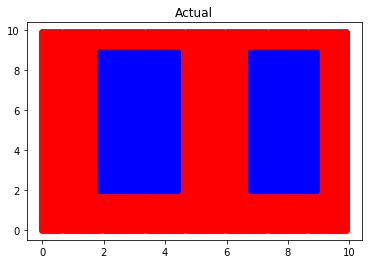

In [14]:
# Take a look at initial data:
print_results()

# Construct neural network

In [22]:
class DeepPixel():
    def __init__(self, input_len, hidden_layers_configuration, output_len, learning_rate=0.1, activation='sigmoid'):
        assert(input_len > 0)
        assert(output_len > 0)

        # Initialize variables to empty
        self.W = []
        self.B = []
        self.errors_history = []
        self.accuracies_history = []
        
        self.predictions = []
        
        self.features = tf.placeholder(tf.float32, [None, input_len])
        self.labels = tf.placeholder(tf.float32, [None, output_len])

        # Weights initialization
        prev_layer_len = input_len
        for i in range(len(hidden_layers_configuration)):
            layer_len = hidden_layers_configuration[i]
            self.W.append(tf.Variable(tf.truncated_normal((prev_layer_len, layer_len)), name="W"+str(i)))
            self.B.append(tf.Variable(tf.zeros((1, layer_len)), name="B"+str(i)))
            prev_layer_len = layer_len
        self.W.append(tf.Variable(tf.truncated_normal((prev_layer_len, output_len)), name="W_output"))
        self.B.append(tf.Variable(tf.zeros((1, output_len)), name="B_output"))
        
        # Forward propagation graph
        prev_layer_output = self.features
        for i in range(len(hidden_layers_configuration)):
            layer_output = prev_layer_output @ self.W[i] + self.B[i];
            if activation=='relu':
                layer_output = tf.nn.relu(layer_output)
            elif activation=='tanh':
                layer_output = tf.nn.tanh(layer_output)
            else:
                layer_output = tf.nn.sigmoid(layer_output)
            prev_layer_output = layer_output
        if output_len == 1:
            self.output = tf.nn.sigmoid(prev_layer_output @ self.W[-1] + self.B[-1])
        else:
            self.output = tf.nn.softmax(prev_layer_output @ self.W[-1] + self.B[-1]) # this branch is not finished
            
        # Error
        self.error = tf.reduce_mean((self.labels - self.output) ** 2)
        
        # Optimizer
        self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(self.error)
        
        init = tf.global_variables_initializer()
        sess = tf.InteractiveSession() # open interactive session
        sess.run(init)
        self.sess = sess
        
    def train(self, X, Y, epochs=100, accuracy_func=None, verbose=0, showChange=False):
        for i in range(epochs):
            e, _ = self.sess.run([self.error, self.optimizer], feed_dict={self.features: X, self.labels: Y})
            if i % int(epochs/100) == 0:
                self.errors_history.append(e)
                predictions = self.predict(X)
                self.predictions.append(predictions)
                if accuracy_func is not None:
                    acc = accuracy_func(Y, predictions)
                    self.accuracies_history.append(acc)
            if i % int(epochs/10) == 0 and verbose > 0:
                if verbose > 1:
                    print("error", e)
                if accuracy_func is not None:
                    print("accuracy", acc)
                if showChange:
                    print_results(predictions)
                pass
            
    def print_history(self):
        plt.figure()
        ax1 = plt.subplot(1, 2, 1)
        ax1.set_title('error')
        ax1.plot(self.errors_history)

        ax2 = plt.subplot(1, 2, 2)
        ax2.set_title('accuracy')
        ax2.plot(self.accuracies_history)
            
    def predict(self, X):
        return self.sess.run(self.output, feed_dict={self.features: X})
    
    def close(self):
        self.sess.close()

In [23]:
# Normalize input:
X_opt = normalize(X)

In [27]:
# Start with relu activation:
nn = DeepPixel(2, [10,10], 1, 0.1, activation='relu')

In [28]:
nn.train(X_opt, Y, 5000, accuracy, 1, False)

accuracy 0.6633
accuracy 0.7152
accuracy 0.7678
accuracy 0.8464
accuracy 0.9024
accuracy 0.9281
accuracy 0.9503
accuracy 0.9644
accuracy 0.9704
accuracy 0.9731


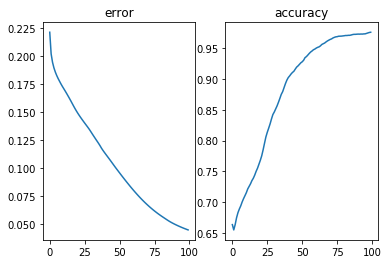

In [29]:
nn.print_history()

# Looks good. Let's visualize that.

In [39]:
def visualize(features, predictions):
    fig, ax1 = plt.subplots()
    #make last shot stay longer:
    last_training = predictions[-1]
    for i in range(15):
        predictions.append(last_training)
    
    pred = predictions[0]
    ones = features[np.argwhere(pred>0.5)]
    zeroes = features[np.argwhere(pred<=0.5)]
    pt1 = plt.plot([s[0,0] for s in zeroes], [s[0,1] for s in zeroes], '.', color = 'red', animated=True)[0]
    pt2 = plt.plot([s[0,0] for s in ones], [s[0,1] for s in ones], '.', color = 'blue', animated=True)[0]

    def animate(i):
        ones = features[np.argwhere(predictions[i]>0.5)]
        zeroes = features[np.argwhere(predictions[i]<=0.5)]
        pt1.set_data([s[0,0] for s in zeroes], [s[0,1] for s in zeroes])
        pt2.set_data([s[0,0] for s in ones], [s[0,1] for s in ones])
        return pt1, 

    anim = FuncAnimation(fig, animate)
    plt.close()
    return HTML(anim.to_html5_video())

In [40]:
visualize(X, nn.predictions)

# Now let's try the opposite task, and for given label predict possible feature

In [45]:
_x = tf.Variable(tf.truncated_normal((1, 2)), name="predictable_x")
_y = tf.placeholder(tf.float32, [1,1])

_w = []
_b = []
W_c = nn.sess.run(nn.W)
B_c = nn.sess.run(nn.B)
for i in range(len(W_c)):
    _w.append(tf.constant(W_c[i], name="w"+str(i)))
    _b.append(tf.constant(B_c[i], name="b"+str(i)))

# Forward propagation graph
prev_layer_output = _x
for i in range(len(W_c) - 1):
    layer_output = tf.nn.relu(prev_layer_output @ _w[i] + _b[i])
    prev_layer_output = layer_output
output = tf.nn.sigmoid(prev_layer_output @ _w[-1] + _b[-1])

error = tf.reduce_mean((_y - output)**2)

optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(error)
init = tf.global_variables_initializer()

In [51]:
X_pred = 0
with tf.Session() as p_sess:
    p_sess.run(init)
    epochs = 10000
    #print(p_sess.run(_w))
    for i in range(epochs):
        e, o, _ = p_sess.run([error, output, optimizer], feed_dict={_y:np.array([[1]])})
        if i % (epochs/10) == 0:
            print('error:',e,'output:',o)
        
    X_pred = p_sess.run(_x)
    print(X_pred)

error: 0.999977 output: [[  1.15987450e-05]]
error: 0.999949 output: [[  2.52627106e-05]]
error: 0.000557103 output: [[ 0.97639698]]
error: 0.000249305 output: [[ 0.98421061]]
error: 0.000206095 output: [[ 0.98564398]]
error: 0.000192283 output: [[ 0.9861334]]
error: 0.000180189 output: [[ 0.98657656]]
error: 0.000169525 output: [[ 0.98697984]]
error: 0.00016003 output: [[ 0.98734969]]
error: 0.000151537 output: [[ 0.98768997]]
[[ 0.19152988  0.06672342]]


In [55]:
# unnormalize projected feature value to be able to use it:
X_true = unnormalize(X, X_pred)

In [58]:
# print actual data + predicted point on top of that:
def print_predicted(x):
    plt.figure()

    ax2 = plt.subplot(1, 1, 1)
    ax2.set_title('Actual')
    ones = X[np.argwhere(Y==1)]
    zeroes = X[np.argwhere(Y==0)]
    ax2.plot([s[0,0] for s in zeroes], [s[0,1] for s in zeroes], '.', color = 'red')
    ax2.plot([s[0,0] for s in ones], [s[0,1] for s in ones], '.', color = 'blue')
    ax2.plot(x[0,0], x[0,1], 'o', color='black')

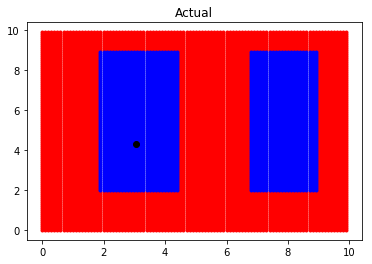

In [59]:
print_predicted(X_true)

### Seems good so far, now let's do the same operation in the bulk

In [88]:
def print_predicted_bulk(x):
    plt.figure()

    ax2 = plt.subplot(1, 1, 1)
    ax2.set_title('Actual')
    ones = X[np.argwhere(Y==1)]
    zeroes = X[np.argwhere(Y==0)]
    ax2.plot([s[0,0] for s in zeroes], [s[0,1] for s in zeroes], '.', color = 'red')
    ax2.plot([s[0,0] for s in ones], [s[0,1] for s in ones], '.', color = 'blue')
    ax2.plot(x[:,0], x[:,1], 'o', color='black')

In [123]:
def find_features_by_target_label(count, target, epochs, activation='sigmoid', custom_features_initialization=None):
    
    if custom_features_initialization is None:
        _x_ = tf.truncated_normal((count, 2))
    else:
        _x_ = custom_features_initialization(count, 2)
        
    _x = tf.Variable(_x_, name="predictable_x")
    _y = tf.placeholder(tf.float32, [count,1])

    _w = []
    _b = []
    W_c = nn.sess.run(nn.W)
    B_c = nn.sess.run(nn.B)
    for i in range(len(W_c)):
        _w.append(tf.constant(W_c[i], name="w"+str(i)))
        _b.append(tf.constant(B_c[i], name="b"+str(i)))

    # Forward propagation graph
    prev_layer_output = _x
    for i in range(len(W_c) - 1):
        layer_output = prev_layer_output @ _w[i] + _b[i]
        if activation=='relu':
            layer_output = tf.nn.relu(layer_output)
        elif activation=='tanh':
            layer_output = tf.nn.tanh(layer_output)
        else:
            layer_output = tf.nn.sigmoid(layer_output)
        prev_layer_output = layer_output
    output = tf.nn.sigmoid(prev_layer_output @ _w[-1] + _b[-1])

    error = tf.reduce_mean((_y - output)**2)

    optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(error)
    init = tf.global_variables_initializer()
    
    X_preds=[]
    X_pred = 0
    with tf.Session() as p_sess:
        p_sess.run(init)
        for i in range(epochs):
            e, o, _ = p_sess.run([error, output, optimizer], feed_dict={_y:np.array(np.array([[target_label] for i in range(count)]))})
            if i % (epochs/100) == 0:
                X_pred = p_sess.run(_x)
                X_preds.append(X_pred)
            if i % (epochs/10) == 0:
                print('error:',e)
        X_pred = p_sess.run(_x)
    return X_pred, X_preds

In [ ]:
count = 1000
target_label = 1
X_pred, _ = find_features_by_target_label(count, target_label, 100000, 'relu')

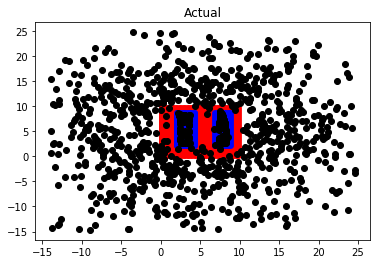

In [95]:
X_true = unnormalize(X, X_pred)
print_predicted_bulk(X_true)

### As we can see, some data got it right, but it most of points didn't make it

In [96]:
print("Data in the right position by target label, percents:", np.count_nonzero(nn.predict(X_pred) > 0.5) / count * 100)

Data in the right position by target label, percents: 14.399999999999999


# My intuition is that relu is having a hard time predicting features with possible negative output. I'm going to take a shot with retrained nn with tanh activation function. But how did relu was able to participate in finding weights, which also could be negative? Something's not right.

In [100]:
nn = DeepPixel(2, [10,10], 1, 0.1, activation='tanh')
nn.train(X_opt, Y, 10000, accuracy, 1, False)

accuracy 0.5468
accuracy 0.7278
accuracy 0.7909
accuracy 0.8147
accuracy 0.8327
accuracy 0.8506
accuracy 0.8737
accuracy 0.925
accuracy 0.9537
accuracy 0.9583


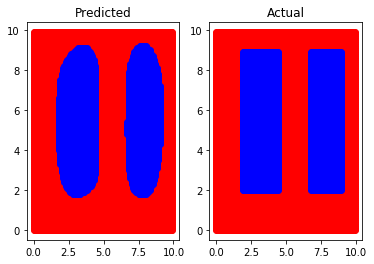

In [101]:
print_results(nn.predict(X_opt))

In [107]:
count = 1000
target_label = 1
X_pred, _ = find_features_by_target_label(count, target_label, 100000, 'tanh')

error: 0.81207
error: 0.684003
error: 0.636854
error: 0.613478
error: 0.592583
error: 0.575315
error: 0.557564
error: 0.546989
error: 0.53481
error: 0.527858


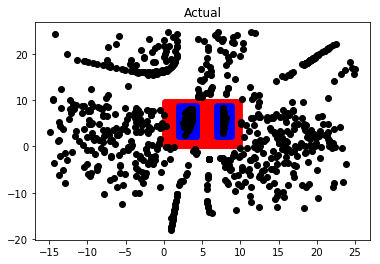

In [108]:
X_true = unnormalize(X, X_pred)
print_predicted_bulk(X_true)

In [109]:
print("Data in the right position by target label, percents:", np.count_nonzero(nn.predict(X_pred) > 0.5) / count * 100)

Data in the right position by target label, percents: 42.5


### I've got 42.5% of data points right. Gonna retry that with better initialization of variables

In [218]:
def custom_init(c, l):
    #since the features passed in nn are bound by [-0.5, 0.5], it is more effective and promising to initialize it as close to zero as possible.
    return tf.truncated_normal((count, l), mean=0.0, stddev=0.21)

In [219]:
count = 1000
target_label = 1
X_pred, X_pred_hist = find_features_by_target_label(count, target_label, 30000, 'tanh', custom_features_initialization=custom_init)

error: 0.412156
error: 0.118612
error: 0.0616344
error: 0.0350829
error: 0.0248947
error: 0.0158284
error: 0.0138694
error: 0.0105073
error: 0.00874591
error: 0.0065862


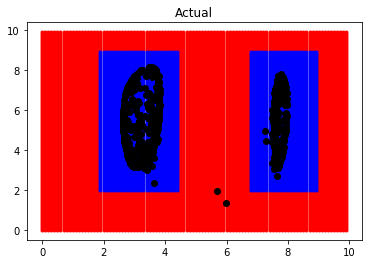

In [220]:
X_true = unnormalize(X, X_pred)
print_predicted_bulk(X_true)

In [221]:
print("Data in the right position by target label, percents:", np.count_nonzero(nn.predict(X_pred) > 0.5) / count * 100)

Data in the right position by target label, percents: 99.8


In [201]:
def visualize_backward_progress(features_pred, features, labels):
    fig, ax1 = plt.subplots()
    #make last shot stay longer:
    last_training = features_pred[-1]
    for i in range(25):
        features_pred.append(last_training)
    
    features_first = features_pred[0]
    ones = features[np.argwhere(labels>0.5)]
    zeroes = features[np.argwhere(labels<=0.5)]
    pt1 = plt.plot([s[0,0] for s in zeroes], [s[0,1] for s in zeroes], '.', color = 'red', animated=False)[0]
    pt2 = plt.plot([s[0,0] for s in ones], [s[0,1] for s in ones], '.', color = 'blue', animated=False)[0]
    pt3 = plt.plot([s[0] for s in features_first], [s[1] for s in features_first], '.', color = 'black', animated=True)[0]

    def animate(i):
        pt3.set_data([s[0] for s in features_pred[i]], [s[1] for s in features_pred[i]])
        return pt3, 

    anim = FuncAnimation(fig, animate)
    plt.close()
    return HTML(anim.to_html5_video())

In [222]:
#Unnormalize the whole history:
x_hist_true = []
for i in range(len(X_pred_hist)):
    x_true = unnormalize(X, X_pred_hist[i])
    x_hist_true.append(x_true)

In [223]:
visualize_backward_progress(x_hist_true, X, Y)

In [224]:
visualize_backward_progress(x_hist_true, X, nn.predict(X_opt))

# As it turned out, the most important thing in that process is to correctly initialize data. The closer initial xs were to the known field ([-0.5,0.5]), the better the performance was. 
Most likely, it is applicable to weights initialization, so it is very important too.

The secondary great thing I got from that project, is that by doing the backward process long enough with randomly initialized data I can get the almost perfect outlining of the "100% sure" area,  because nn would keep moving xs toward the more certain area. Also, some point that were initialized closer to the edge or beyond it tend to form some weird patterns, which are rather great illustration of overfitting.